In [33]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [127]:
import numpy as np

BATCH_SIZE = 10
SEED = 0

In [ ]:
# Get the data files (No need to run if local notebook)
!wget 'https://gist.github.com/xh313/778e8e4a1b568b1289073dec551eb554/archive/df6ecb8cef3302fca7c24a92ef4e2fcd59e04ee8.zip'  # train
!unzip 'df6ecb8cef3302fca7c24a92ef4e2fcd59e04ee8.zip' && mv "778e8e4a1b568b1289073dec551eb554-df6ecb8cef3302fca7c24a92ef4e2fcd59e04ee8/cs159_training.txt" "/content/"
!wget 'https://gist.github.com/xh313/2af9b2bc748fa316125a086737321bb7/archive/830f9427b85863dcf2f63e4c8c55bae9373ce132.zip' # test
!unzip '830f9427b85863dcf2f63e4c8c55bae9373ce132.zip' && mv "2af9b2bc748fa316125a086737321bb7-830f9427b85863dcf2f63e4c8c55bae9373ce132/cs159_testing.txt" "/content/"

In [139]:
import re

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            # Split the line by the tab character
            parts = line.split("\t")
            if parts[0] == "negative":
              t = 0
            elif parts[0] == "positive":
              t = 1

            # Now strip off weird punctuations because the Bobcat parser doesn't like it
            sentence = re.sub(r'[-#$:] ', ', ', parts[1].strip()).strip()

            # Some lines have more sentences so we split them
            fullstops = re.split(r' [.!?] ', sentence)

            # (NO LONGER) Only use sentences sufficiently short because trainer is slow
            for fullstop in fullstops:
              # if len(re.findall(r'\b\w+\b', fullstop)) <= 8:
                sentences.append(fullstop.strip())
                labels.append([t, 1-t])  # Make label a vector-like thing

    f.close()
    return labels, sentences

# If using Google Colab, make sure these files are there by running the cell above!
# train_labels, train_data = read_data('cs159_training.txt')
# val_labels, val_data = read_data('cs159_testing.txt')
train_labels, train_data = read_data('rp_train_data.txt')
val_labels, val_data = read_data('rp_test_data.txt')

In [140]:
# Inspection
train_data[:10]

['boring plot not funny everything went wrong',
 'terrible movie',
 'way too much whoopi !',
 'whoopie , painful as always .',
 'sad , i actually do like adam sandler',
 "he is a decent comedian , but he can't act",
 'and what is it with his films',
 "they just don't seem to have any signs of a cohesive plot to them .",
 "adam sandler shows once again he can't act in this travesty that has him using profanity around little children and knocking mcdonalds",
 'most humor is quite sick and this movie is horrid']

In [ ]:
# Change % into ! IF USING GOOGLE COLAB
%pip install lambeq 
# %pip install "discopy>=1.1.0"
# %pip install "pytket-qiskit==0.50.0"
# !pip install "pytket-qiskit==0.60.0"
%pip install "pytket-qiskit~=0.50.0" --use-deprecated=legacy-resolver

In [7]:
from lambeq import BobcatParser, Rewriter

# Initialize the parser (Warning: Takes forever)
parser = BobcatParser()

In [141]:
# Parse sentences into pregroup grammar
# (Warning: Takes forever if you have lots of sentences)
# the [:10] below is to save time when testing if the code runs
raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences:   0%|          | 0/75 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/300 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/300 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/3 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/12 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/12 [00:00<?, ?it/s]

In [142]:
# Organize the labels and the diagrams; diagrams converted to normal form
# (Warning: Takes a nontrivial amount of time but not forever)
train_diagrams = [
    diagram.pregroup_normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.pregroup_normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]

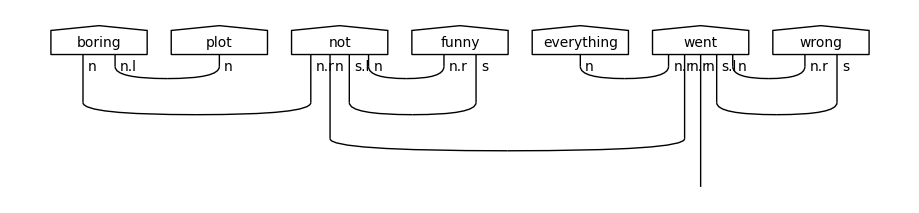

In [143]:
# Sample diagram of a negative review
train_diagrams[0].draw(figsize=(9, 5), fontsize=10)

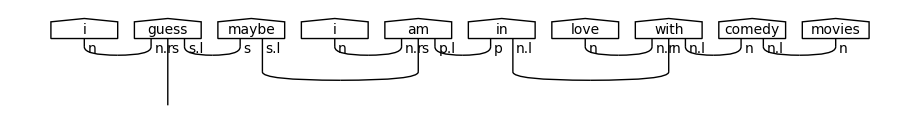

In [144]:
# Positive one
train_diagrams[-3].draw(figsize=(9, 5), fontsize=10)

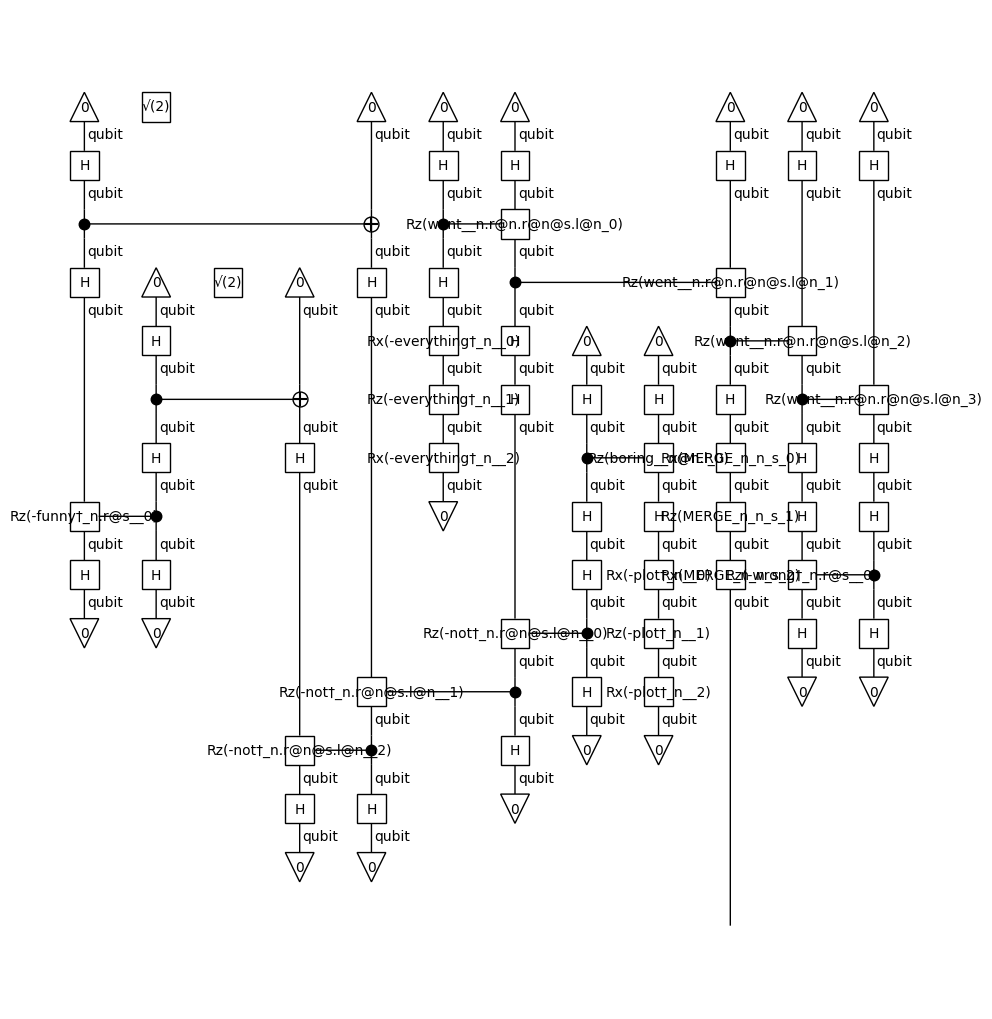

In [145]:
from lambeq import AtomicType, IQPAnsatz, RemoveCupsRewriter, UnifyCodomainRewriter
# from lambeq.backend.tensor import Dim

# Define atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE
codo_rewriter = UnifyCodomainRewriter(AtomicType.SENTENCE)  #  Codomain should be always S

# Convert string diagram to quantum circuit
ansatz = IQPAnsatz({N: 1, S: 1, P: 0}, n_layers=1,
                   n_single_qubit_params=3)

remove_cups = RemoveCupsRewriter()

# Apply the Ansatz to the parses (Warning: takes nontrivial time)
train_circuits = [ansatz(codo_rewriter(remove_cups(diagram))) for diagram in train_diagrams]
val_circuits =  [ansatz(codo_rewriter(remove_cups(diagram)))  for diagram in val_diagrams]

train_circuits[0].draw(figsize=(9, 10))

In [146]:
all_circuits = train_circuits + val_circuits

# One model from Tket
# from pytket.extensions.qiskit import AerBackend
# from lambeq import TketModel
# backend = AerBackend()
# backend_config = {
#     'backend': backend,
#     'compilation': backend.default_compilation_pass(2),
#     'shots': 8192
# }
# model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

# Alternative model using Numpy (uses less memory)
from lambeq import NumpyModel
model = NumpyModel.from_diagrams(all_circuits)

## Training

In [150]:
# Define a loss function
epsilon = 1e-9  # smoothing to prevent log 0
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat + epsilon)) / len(y)

# Or use the built-in binary cross-entropy error from lambeq
from lambeq import BinaryCrossEntropyLoss
bce = BinaryCrossEntropyLoss()

# Define an accuracy function: when does the classification go to the correct side?
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [151]:
# Trainer, training set and test set

from lambeq import QuantumTrainer, SPSAOptimizer, Dataset

EPOCHS = 10

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose='text',
    log_dir='RelPron/logs',
    seed=0
)

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [152]:
# Train the model
trainer.fit(train_dataset,
            val_dataset,
            early_stopping_criterion='acc',
            early_stopping_interval=10,
            log_interval=1,
            minimize_criterion=False)

Epoch 1:   train/loss: 0.7878   valid/loss: 1.4189   train/acc: 0.5493   valid/acc: 0.5000
Epoch 2:   train/loss: 1.3790   valid/loss: 1.6786   train/acc: 0.5237   valid/acc: 0.5000
Epoch 3:   train/loss: 0.4224   valid/loss: 1.5899   train/acc: 0.5584   valid/acc: 0.4167
Epoch 4:   train/loss: 0.9273   valid/loss: 1.5613   train/acc: 0.5639   valid/acc: 0.3333
Epoch 5:   train/loss: 0.3543   valid/loss: 1.6538   train/acc: 0.5693   valid/acc: 0.3333
Epoch 6:   train/loss: 0.5324   valid/loss: 1.4853   train/acc: 0.5967   valid/acc: 0.3750
Epoch 7:   train/loss: 0.6148   valid/loss: 1.3412   train/acc: 0.5529   valid/acc: 0.5833
Epoch 8:   train/loss: 0.4382   valid/loss: 1.5896   train/acc: 0.5803   valid/acc: 0.4167
Epoch 9:   train/loss: 1.0627   valid/loss: 1.5649   train/acc: 0.5401   valid/acc: 0.4167
Epoch 10:  train/loss: 1.2431   valid/loss: 1.5281   train/acc: 0.5420   valid/acc: 0.3333

Training completed!


Validation accuracy: 0.5833333333333334


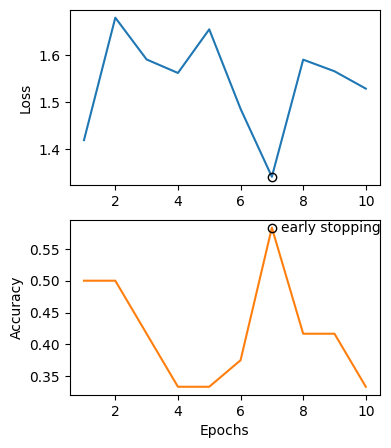

In [162]:
# Plotting
import matplotlib.pyplot as plt

fig, ((#ax_tl, ax_bl, 
       ax_tr, ax_br)) = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(4, 5))
# ax_tl.set_title('Training set')
# ax_bl.set_xlabel('Epochs')
# ax_bl.set_ylabel('Accuracy')
# ax_tl.set_ylabel('Loss')
# ax_tr.set_title('Testing set')
ax_br.set_xlabel('Epochs')
ax_br.set_ylabel('Accuracy')
ax_tr.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, len(trainer.train_epoch_costs)+1)
# ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
# ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# # mark best model as circle
best_epoch = np.argmax(trainer.val_eval_results['acc'])
# ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
# ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_br.text(best_epoch + 1.3, trainer.val_eval_results['acc'][best_epoch], 'early stopping', va='center')

# print test accuracy
model.load(trainer.log_dir + '/best_model.lt')
val_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', val_acc.item())